# Задание 2.2 - Введение в PyTorch

Для этого задания потребуется установить версию PyTorch 1.0

https://pytorch.org/get-started/locally/

В этом задании мы познакомимся с основными компонентами PyTorch и натренируем несколько небольших моделей.<br>
GPU нам пока не понадобится.

Основные ссылки:  
https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html  
https://pytorch.org/docs/stable/nn.html  
https://pytorch.org/docs/stable/torchvision/index.html  

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler

from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

## Как всегда, начинаем с загрузки данных

PyTorch поддерживает загрузку SVHN из коробки.

In [2]:
# First, lets load the dataset
data_train = dset.SVHN('../data/', split='train',
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('../data/', split='test', 
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Теперь мы разделим данные на training и validation с использованием классов `SubsetRandomSampler` и `DataLoader`.

`DataLoader` подгружает данные, предоставляемые классом `Dataset`, во время тренировки и группирует их в батчи.
Он дает возможность указать `Sampler`, который выбирает, какие примеры из датасета использовать для тренировки. Мы используем это, чтобы разделить данные на training и validation.

Подробнее: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [3]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

В нашей задаче мы получаем на вход изображения, но работаем с ними как с одномерными массивами. Чтобы превратить многомерный массив в одномерный, мы воспользуемся очень простым вспомогательным модулем `Flattener`.

In [4]:
sample, label = data_train[0]
print("SVHN data sample shape: ", sample.shape)
# As you can see, the data is shaped like an image

# We'll use a special helper module to shape it into a tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

SVHN data sample shape:  torch.Size([3, 32, 32])


И наконец, мы создаем основные объекты PyTorch:
- `nn_model` - собственно, модель с нейросетью
- `loss` - функцию ошибки, в нашем случае `CrossEntropyLoss`
- `optimizer` - алгоритм оптимизации, в нашем случае просто `SGD`

In [5]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

# We will minimize cross-entropy between the ground truth and
# network predictions using an SGD optimizer
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

## Тренируем!

Ниже приведена функция `train_model`, реализующая основной цикл тренировки PyTorch.

Каждую эпоху эта функция вызывает функцию `compute_accuracy`, которая вычисляет точность на validation, эту последнюю функцию предлагается реализовать вам.

In [6]:
# This is how to implement the same main train loop in PyTorch. Pretty easy, right?

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        predicted_true = 0
        total = 0
        for i_step, (x, y) in enumerate(train_loader):
            preds = model(x)    
            loss_value = loss(preds, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, idxs = torch.max(preds, 1)
            predicted_true += torch.sum(idxs == y)
            total += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(predicted_true) / total
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Implement the inference of the model on all of the batches from loader,
    #       and compute the overall accuracy.
    # Hint: PyTorch has the argmax function!
    predicted_true_count = 0
    total_checked = 0
    for x, y in loader:
        preds = model(x)
        idxs = torch.argmax(preds, dim = 1)
        predicted_true_count += torch.sum(idxs == y)
        total_checked += y.shape[0]
    accuracy = float(predicted_true_count) / total_checked
    return accuracy

In [7]:
loss_history, train_history, val_history = train_model(nn_model, 
                                                       train_loader, 
                                                       val_loader, 
                                                       loss, 
                                                       optimizer, 
                                                       3)

Average loss: 1.800738, Train accuracy: 0.423523, Val accuracy: 0.556344
Average loss: 1.452249, Train accuracy: 0.582705, Val accuracy: 0.617705
Average loss: 1.383437, Train accuracy: 0.617479, Val accuracy: 0.634155


## После основного цикла

Посмотрим на другие возможности и оптимизации, которые предоставляет PyTorch.

Добавьте еще один скрытый слой размера 100 нейронов к модели

In [8]:
# Since it's so easy to add layers, let's add some!

# TODO: Implement a model with 2 hidden layers of the size 100

nn_model = nn.Sequential(
        Flattener(),
        nn.Linear(in_features = 3072, out_features = 100),
        nn.ReLU(inplace=True),
        nn.Linear(in_features = 100, out_features = 100),
        nn.ReLU(inplace = True),
        nn.Linear(in_features = 100, out_features = 10)
       )

nn_model.type(torch.FloatTensor)

optimizer = optim.SGD(nn_model.parameters(), 
                      lr=1e-2, 
                      weight_decay=1e-1)

loss_history, train_history, val_history = train_model(nn_model, 
                                                       train_loader, 
                                                       val_loader, 
                                                       loss, 
                                                       optimizer, 
                                                       5)

Average loss: 2.169768, Train accuracy: 0.196106, Val accuracy: 0.222306
Average loss: 2.012157, Train accuracy: 0.272208, Val accuracy: 0.322504
Average loss: 1.823700, Train accuracy: 0.369894, Val accuracy: 0.409324
Average loss: 1.716379, Train accuracy: 0.415521, Val accuracy: 0.439765
Average loss: 1.684123, Train accuracy: 0.433437, Val accuracy: 0.442768


Добавьте слой с Batch Normalization

In [9]:
# We heard batch normalization is powerful, let's use it!
# TODO: Add batch normalization after each of the hidden layers of the network, before or after non-linearity
# Hint: check out torch.nn.BatchNorm1d

nn_model = nn.Sequential(
        Flattener(),
        nn.Linear(in_features = 3072, out_features = 100),
        nn.BatchNorm1d(num_features = 100),
        nn.ReLU(inplace=True),
        nn.Linear(in_features = 100, out_features = 100),
        nn.ReLU(inplace = True),
        nn.BatchNorm1d(num_features = 100),
        nn.Linear(in_features = 100, out_features = 10)
         )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 1.915488, Train accuracy: 0.390250, Val accuracy: 0.559825
Average loss: 1.503589, Train accuracy: 0.596833, Val accuracy: 0.645894
Average loss: 1.340980, Train accuracy: 0.654370, Val accuracy: 0.674084
Average loss: 1.253175, Train accuracy: 0.679128, Val accuracy: 0.684185
Average loss: 1.200594, Train accuracy: 0.695014, Val accuracy: 0.722135


Добавьте уменьшение скорости обучения по ходу тренировки.

In [10]:
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

# nn_model = nn.Sequential(
#          )

In [11]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        predicted_true = 0
        total = 0
        for i_step, (x, y) in enumerate(train_loader):
            preds = model(x)    
            loss_value = loss(preds, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, idxs = torch.max(preds, 1)
            predicted_true += torch.sum(idxs == y)
            total += y.shape[0]
            
            loss_accum += loss_value
            
            
        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(predicted_true) / total
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        # SCHEDULER USE
        scheduler.step()
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
sched = optim.lr_scheduler.StepLR(optimizer = optimizer, 
                          step_size = 2, 
                          gamma=0.5)

In [12]:
loss_history, train_history, val_history = train_model(
                                                    model=nn_model, 
                                                    train_loader=train_loader, 
                                                    val_loader=val_loader, 
                                                    loss=loss,
                                                    optimizer = optimizer, 
                                                    num_epochs = 10,
                                                    scheduler = sched)

Average loss: 1.168557, Train accuracy: 0.704092, Val accuracy: 0.734830
Average loss: 1.146732, Train accuracy: 0.713272, Val accuracy: 0.728483
Average loss: 1.099122, Train accuracy: 0.736682, Val accuracy: 0.744727
Average loss: 1.086932, Train accuracy: 0.740368, Val accuracy: 0.758174
Average loss: 1.062202, Train accuracy: 0.751903, Val accuracy: 0.754897
Average loss: 1.054788, Train accuracy: 0.757312, Val accuracy: 0.764248
Average loss: 1.044187, Train accuracy: 0.761594, Val accuracy: 0.766978
Average loss: 1.041265, Train accuracy: 0.761953, Val accuracy: 0.767661
Average loss: 1.034633, Train accuracy: 0.766560, Val accuracy: 0.770528
Average loss: 1.031445, Train accuracy: 0.766236, Val accuracy: 0.770323


# Визуализируем ошибки модели

Попробуем посмотреть, на каких изображениях наша модель ошибается.
Для этого мы получим все предсказания модели на validation set и сравним их с истинными метками (ground truth).

Первая часть - реализовать код на PyTorch, который вычисляет все предсказания модели на validation set.  
Чтобы это сделать мы приводим код `SubsetSampler`, который просто проходит по всем заданным индексам последовательно и составляет из них батчи. 

Реализуйте функцию `evaluate_model`, которая прогоняет модель через все сэмплы validation set и запоминает предсказания модели и истинные метки.

In [13]:
class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of ints - model predictions
    grount_truth: np array of ints - actual labels of the dataset
    """
    model.eval() # Evaluation mode
    
    # TODO: Evaluate model on the list of indices and capture predictions
    # and ground truth labels
    # Hint: SubsetSampler above could be useful!
    
    ss, batch_size = SubsetSampler(indices), 128
    predictions, ground_truth = [], []

    loader = torch.utils.data.DataLoader(dataset = dataset, 
                                         batch_size=batch_size,
                                         sampler=ss)
    
    for x,y in loader:
        preds = model(x)
        idxs = torch.argmax(preds, dim = 1)
        predictions.extend(idxs)
        ground_truth.extend(y)
    
    return predictions, ground_truth

# Evaluate model on validation
predictions, gt = evaluate_model(nn_model, data_train, val_indices)
assert len(predictions) == len(val_indices)
assert len(gt) == len(val_indices)
assert gt[100] == data_train[val_indices[100]][1]
assert np.any(np.not_equal(gt, predictions))

## Confusion matrix
Первая часть визуализации - вывести confusion matrix (https://en.wikipedia.org/wiki/Confusion_matrix ).

Confusion matrix - это матрица, где каждой строке соответствуют классы предсказанный, а столбцу - классы истинных меток (ground truth). Число с координатами `i,j` - это количество сэмплов класса `j`, которые модель считает классом `i`.

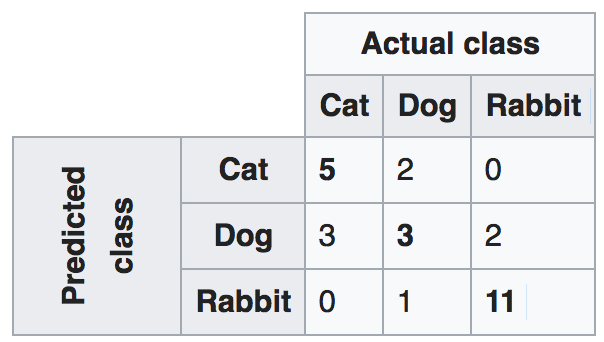

Для того, чтобы облегчить вам задачу, ниже реализована функция `visualize_confusion_matrix` которая визуализирует такую матрицу.  
Вам осталось реализовать функцию `build_confusion_matrix`, которая ее вычислит.

Результатом должна быть матрица 10x10.

In [14]:
def visualize_confusion_matrix(confusion_matrix):
    """
    Visualizes confusion matrix
    
    confusion_matrix: np array of ints, x axis - predicted class, y axis - actual class
                      [i][j] should have the count of samples that were predicted to be class i,
                      but have j in the ground truth
                     
    """
    # Adapted from 
    # https://stackoverflow.com/questions/2897826/confusion-matrix-with-number-of-classified-misclassified-instances-on-it-python
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10,10))
    plt.title("Confusion matrix")
    plt.ylabel("predicted")
    plt.xlabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, 
                     count, 
                     fontsize=15, 
                     horizontalalignment='center', 
                     verticalalignment='center')
    
def build_confusion_matrix(predictions, ground_truth):
    """
    Builds confusion matrix from predictions and ground truth

    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    
    Returns:
    np array of ints, (10,10), counts of samples for predicted/ground_truth classes
    """
    
    confusion_matrix = np.zeros((10,10), np.int)
    
    # TODO: Implement filling the prediction matrix
    for x,y in zip(predictions, gt):
        confusion_matrix[x,y] += 1
    
    return confusion_matrix
#     return np.array([[40, 2, 3], [10, 50,0], [0, 2, 80]])

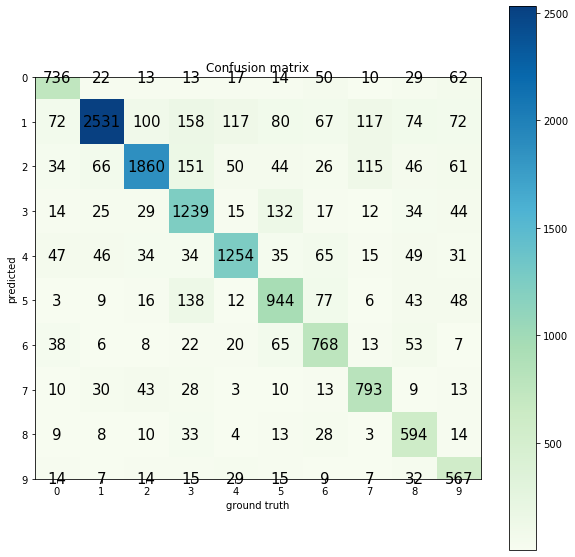

In [15]:
confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

Наконец, посмотрим на изображения, соответствующие некоторым элементам этой матрицы.

Как и раньше, вам дана функция `visualize_images`, которой нужно воспрользоваться при реализации функции `visualize_predicted_actual`. Эта функция должна вывести несколько примеров, соответствующих заданному элементу матрицы.

Визуализируйте наиболее частые ошибки и попробуйте понять, почему модель их совершает.

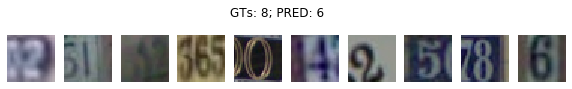

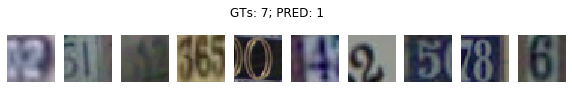

In [16]:
data_train_images = dset.SVHN('./../data/', split='train')

def visualize_images(indices, data, title='', max_num=10):
    """
    Visualizes several images from the dataset
 
    indices: array of indices to visualize
    data: torch Dataset with the images
    title: string, title of the plot
    max_num: int, max number of images to display
    """
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(10,1.5))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1,to_show, i+1)
        plt.axis('off')
        sample = data[index][0]
        plt.imshow(sample)
        
def visualize_predicted_actual(predicted_class, gt_class, predictions, groud_truth, val_indices, data):
    """
    Visualizes images of a ground truth class which were predicted as the other class 
    
    predicted: int 0-9, index of the predicted class
    gt_class: int 0-9, index of the ground truth class
    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    val_indices: np array of ints, indices of validation samples
    """

    # TODO: Implement visualization using visualize_images above
    # predictions and ground_truth are provided for validation set only, defined by val_indices
    # Hint: numpy index arrays might be helpful
    # https://docs.scipy.org/doc/numpy/user/basics.indexing.html#index-arrays
    # Please make the title meaningful!
    idxs = []
    for i, (pred, gt) in enumerate(zip(predictions, groud_truth)):
        if predicted_class == pred and gt_class == gt:
            ith_samples_indices = val_indices[i]
            idxs.append(ith_samples_indices)
    visualize_images(indices, data, f'GTs: {gt_class}; PRED: {predicted_class}')
    
    # почему-то, если использовать
    # idxs = [(predictions == predicted_class) and (ground_truth == gt_class)]
    # , то не работает вывод картинок ._. 

visualize_predicted_actual(6, 8, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 7, predictions, gt, np.array(val_indices), data_train_images)

# Переходим к свободным упражнениям!

Натренируйте модель как можно лучше - экспериментируйте сами!
Что следует обязательно попробовать:
- перебор гиперпараметров с помощью валидационной выборки
- другие оптимизаторы вместо SGD
- изменение количества слоев и их размеров
- наличие Batch Normalization

Но ограничиваться этим не стоит!

Точность на тестовой выборке должна быть доведена до **80%**

In [ ]:
# # First, lets load the dataset
# data_train = dset.SVHN('../data/', split='train',
#                        transform=transforms.Compose([
#                            transforms.ToTensor(),
#                            transforms.Normalize(mean=[0.43,0.44,0.47],
#                                                std=[0.20,0.20,0.20])                           
#                        ])
#                       )
# data_test = dset.SVHN('../data/', split='test', 
#                       transform=transforms.Compose([
#                            transforms.ToTensor(),
#                            transforms.Normalize(mean=[0.43,0.44,0.47],
#                                                std=[0.20,0.20,0.20])                           
#                        ]))

# batch_size = 64

# data_size = data_train.data.shape[0]
# validation_split = .2
# split = int(np.floor(validation_split * data_size))
# indices = list(range(data_size))
# np.random.shuffle(indices)

# train_indices, val_indices = indices[split:], indices[:split]

# train_sampler = SubsetRandomSampler(train_indices)
# val_sampler = SubsetRandomSampler(val_indices)

# train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
#                                            sampler=train_sampler)
# val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
#                                          sampler=val_sampler)

In [33]:
epochs = 5
batch_size = 128

learning_rates = [1e-4, 1e-3]
weight_decays = [1e-5, 1e-4] # reg
hidden_layer_size = [128]

best_model = None
best_accuracy = None


# lambda1 = lambda epoch: epoch // 30
lambda2 = lambda epoch: 0.98 ** epoch

for rate in learning_rates:
    for decay in weight_decays:
        for size in hidden_layer_size:
            s = f"Learing rate: {rate}; reg strength: {decay}; hidden layer size: {size}"
            print(s)
            
            nn_model = nn.Sequential(
                                    Flattener(),
                                    nn.Linear(in_features = 3072, out_features = size),
                                    nn.BatchNorm1d(num_features = size),
                                    nn.ReLU(inplace=True),
                                    nn.Linear(in_features = size, out_features = size),
                                    nn.ReLU(inplace = True),
                                    nn.BatchNorm1d(num_features = size),
                                    nn.Linear(in_features = size, out_features = 10)
                                     )
            
            scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lambda2])
            loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
            optimizer = optim.Adam(nn_model.parameters(), lr = rate, weight_decay = decay)

            loss_history, train_history, val_history = train_model(
                                                                model=nn_model, 
                                                                train_loader=train_loader, 
                                                                val_loader=val_loader, 
                                                                loss=loss,
                                                                optimizer = optimizer, 
                                                                num_epochs = epochs,
                                                                scheduler = scheduler)
            cur_accuracy = val_history[-1]

            if best_model is None or best_accuracy is None or best_accuracy < cur_accuracy:
                best_model = nn_model
                best_accuracy = cur_accuracy
                
            print()

Learing rate: 0.0001; reg strength: 1e-05; hidden layer size: 128
Average loss: 1.467210, Train accuracy: 0.544893, Val accuracy: 0.687803
Average loss: 1.016841, Train accuracy: 0.693564, Val accuracy: 0.727118
Average loss: 0.884630, Train accuracy: 0.730386, Val accuracy: 0.743021
Average loss: 0.801784, Train accuracy: 0.753660, Val accuracy: 0.778650
Average loss: 0.738962, Train accuracy: 0.772771, Val accuracy: 0.785134

Learing rate: 0.0001; reg strength: 0.0001; hidden layer size: 128
Average loss: 1.508705, Train accuracy: 0.534775, Val accuracy: 0.672446
Average loss: 1.037197, Train accuracy: 0.689793, Val accuracy: 0.723500
Average loss: 0.895016, Train accuracy: 0.730249, Val accuracy: 0.755102
Average loss: 0.812050, Train accuracy: 0.751715, Val accuracy: 0.780425
Average loss: 0.751664, Train accuracy: 0.769665, Val accuracy: 0.772097

Learing rate: 0.001; reg strength: 1e-05; hidden layer size: 128
Average loss: 1.335612, Train accuracy: 0.567587, Val accuracy: 0.6738

In [35]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.7540
